

# **Installing and importing useful libraries**



In [ ]:
# Install required packages
!pip install lightgbm imbalanced-learn shap

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)

from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import shap
import joblib

pd.set_option("display.max_columns", None)

# **Uploading the Dataset from the Machine**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Please replace 'your_path_to_file' with the actual path to your CSV file in Google Drive
file_path = '/content/drive/MyDrive/german_credit_data.csv'
df = pd.read_csv(file_path)

# Clean column names (removes hidden spaces)
df.columns = df.columns.str.strip()

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


# **Performing Basic Data Inspection**

In [ ]:
print("Dataset Shape:", df.shape)
df.info()
df.isnull().sum()

Dataset Shape: (1000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


,0
Unnamed: 0,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,183
Checking account,394
Credit amount,0
Duration,0
Purpose,0


**Dropping unnecessary columns**

In [ ]:
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

**Handling Missing Values**

In [ ]:
# Fill missing categorical values with "Unknown"
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna("Unknown")

**Encoding Target Variable**

In [ ]:
# Handle both 'Risk' and 'risk'
if 'Risk' in df.columns:
    df['Risk'] = df['Risk'].map({'good': 0, 'bad': 1})
    target_column = 'Risk'
elif 'risk' in df.columns:
    df['risk'] = df['risk'].map({'good': 0, 'bad': 1})
    target_column = 'risk'
else:
    raise ValueError("Target column not found!")

df[target_column].value_counts()

,count
Risk,
0,700
1,300


**Encoding Categorical Features**



In [ ]:
categorical_cols = df.select_dtypes(include='object').columns

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

**Splitting Features and Target**

In [ ]:
X = df.drop(target_column, axis=1)
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

**Handling Class Imbalance (SMOTE)**

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:")
print(y_train_res.value_counts())

After SMOTE:
Risk
1    560
0    560
Name: count, dtype: int64


**Train LightGBM Model**

In [ ]:
model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)

model.fit(X_train_res, y_train_res)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 560, number of negative: 560
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 376
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(learning_rate=0.05, n_estimators=500, random_state=42)

# **Model Evaluation**

In [ ]:
#Prediction
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

In [ ]:
#ROC-AUC
roc_score = roc_auc_score(y_test, y_proba)
print("ROC-AUC Score:", roc_score)

ROC-AUC Score: 0.7321428571428571


In [ ]:
#Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       140
           1       0.54      0.50      0.52        60

    accuracy                           0.72       200
   macro avg       0.66      0.66      0.66       200
weighted avg       0.71      0.72      0.72       200



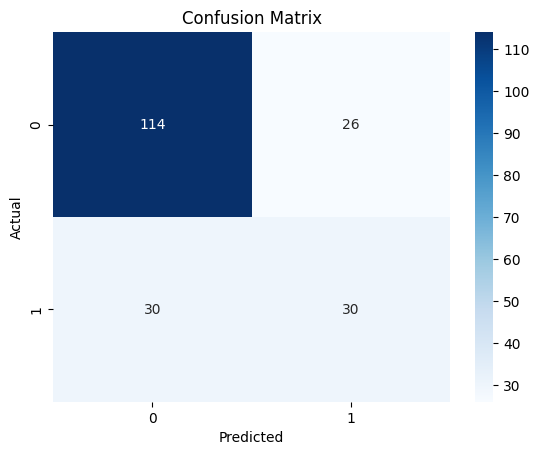

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

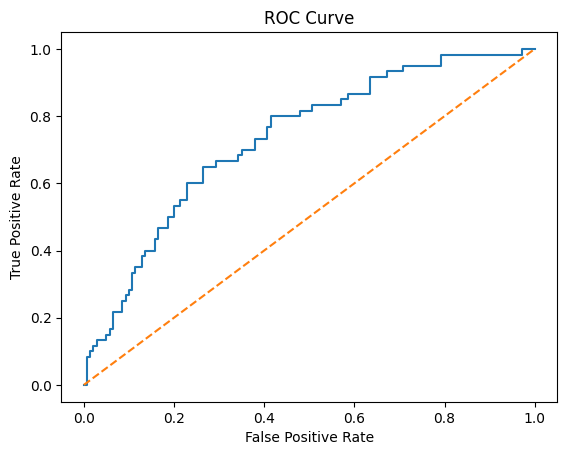

In [31]:
#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# **Feature Importance**

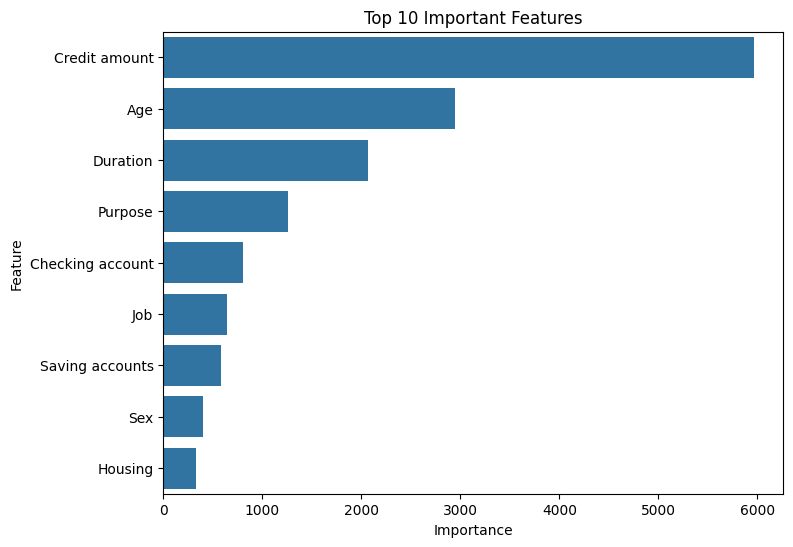

In [ ]:
importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=importance_df.head(10),
            x="Importance",
            y="Feature")
plt.title("Top 10 Important Features")
plt.show()

# **SHAP Explainability**

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


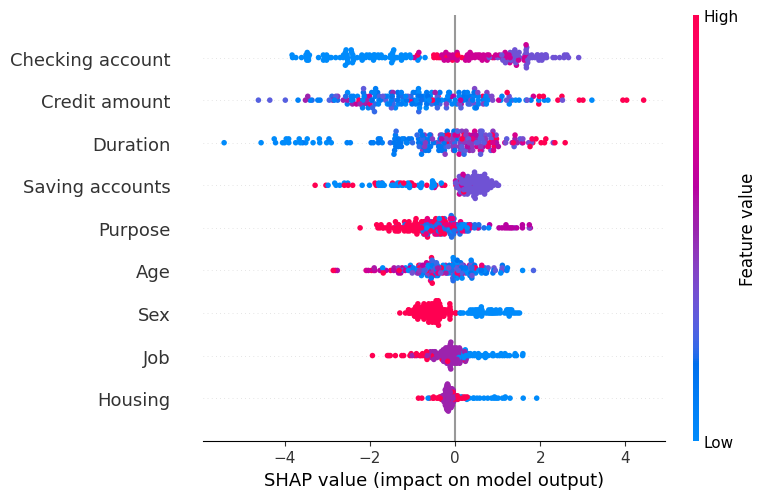

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

# **Saving Model**

In [32]:
joblib.dump(model, "credit_risk_model.pkl")

['credit_risk_model.pkl']

In [33]:
# Select a sample from the test set for prediction
sample_index = 0 # You can change this index to test different samples
sample_data = X_test.iloc[[sample_index]]

print(f"Sample data for prediction (index {sample_index}):")
display(sample_data)

# Make a prediction using the trained model
single_prediction = model.predict(sample_data)
single_prediction_proba = model.predict_proba(sample_data)[:, 1]

# Map the numerical prediction back to 'good' or 'bad'
risk_label = 'bad' if single_prediction[0] == 1 else 'good'

print(f"\nPredicted Risk: {risk_label}")
print(f"Probability of 'bad' risk: {single_prediction_proba[0]:.4f}")
print(f"Actual Risk: {'bad' if y_test.iloc[sample_index] == 1 else 'good'}")

Sample data for prediction (index 0):


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
30,36,1,2,1,4,2,1913,18,0



Predicted Risk: good
Probability of 'bad' risk: 0.0114
Actual Risk: good
